# 🎨 Structured 2D+6D Model Visualization Notebook

**Dedicated Visualization for Pre-Trained Models**

This notebook is designed to load and visualize pre-trained 2D+6D structured autoencoders downloaded from cloud training.

## Key Features:
- **Load Pre-trained Models**: Quick loading from saved .pth files
- **Latent Space Grid Scan**: Interactive exploration of the 2D content latent space
- **Comprehensive Visualizations**: All available visualization functions
- **Affine Transformation Analysis**: Examine learned geometric transformations
- **No Training Required**: Pure visualization and analysis

## Model Architecture:
- **2D Content Latent**: Captures digit identity/shape clustering
- **6D Transform Latent**: Captures spatial transformations (rotation, skew, translation)
- **Simplified Loss**: Uses affine reconstruction + KL divergence on content latent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Handle torchvision compatibility issues
import warnings
warnings.filterwarnings("ignore", message=".*torchvision::nms.*")
warnings.filterwarnings("ignore", category=UserWarning)

# Explicit imports from modular structure with error handling
try:
    import structured_2d6d_autoencoder as s2d6d
    import affine_autoencoder_shared as shared
    # Import visualization functions
    import structured_2d6d_visualization as viz
    
    print("📚 All modules loaded successfully!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Device available: {torch.cuda.is_available() and 'CUDA' or 'CPU'}")
    
except ImportError as e:
    print(f"❌ Module import error: {e}")
    print("\n💡 This is likely due to torchvision compatibility issues.")
    print("🔧 IMMEDIATE FIXES:")
    print("1. Run this in terminal: pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cpu")
    print("2. Or restart kernel and run the troubleshooting cell below")
    print("3. Or run: python fix_torchvision.py")
    
    # Try to continue with minimal imports
    try:
        import torch
        print(f"✅ PyTorch still available: {torch.__version__}")
        print("⚠️ Continuing with limited functionality...")
    except:
        print("❌ Critical error - PyTorch not available")
        raise

Matplotlib is building the font cache; this may take a moment.


📚 All modules loaded successfully!
PyTorch version: 2.7.1
Device available: CPU


In [3]:
# 🔄 FALLBACK IMPORTS (run this if the above cell fails)
# This provides a workaround for torchvision compatibility issues

print("🔄 Attempting fallback imports...")

try:
    # Try to import with compatibility wrapper
    import structured_2d6d_autoencoder as s2d6d
    import affine_autoencoder_shared_compat as shared  # Use compatibility wrapper
    import structured_2d6d_visualization as viz
    
    print("✅ Fallback imports successful!")
    print("⚠️ Using compatibility mode - some features may be limited")
    
    # Override the import in case it was partially loaded
    import sys
    sys.modules['affine_autoencoder_shared'] = shared
    
except Exception as e:
    print(f"❌ Fallback also failed: {e}")
    print("\n🛠️ MANUAL FIXES REQUIRED:")
    print("1. Run in terminal: pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cpu")
    print("2. Restart your kernel completely")
    print("3. Or run: python fix_torchvision.py")
    print("4. Make sure all .py files are in the same directory")
    
    # Provide minimal functionality
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    
    print("⚠️ Continuing with minimal PyTorch functionality only...")
    print("Some visualization features will not be available until imports are fixed.")

🔄 Attempting fallback imports...
✅ Compatibility wrapper loaded successfully!
✅ Fallback imports successful!
⚠️ Using compatibility mode - some features may be limited


In [4]:
# 🔧 CONFIGURATION
# Set up basic configuration for visualization
VIZ_CONFIG = {
    'force_cuda': False,  # Set to True if you want GPU
    'batch_size_test': 128,
    'data_dir': '../data',
    'pin_memory': True,
    'num_workers': 4,
    'grid_size': 30,  # For latent space grid scan
    'latent_range': 3.0,  # Range for latent space scanning (-range to +range)
    'figure_dpi': 100,
    'save_plots': False  # Set to True to save plot images
}

# Get device and data loaders with error handling
try:
    device = shared.get_cloud_device(VIZ_CONFIG) if VIZ_CONFIG['force_cuda'] else torch.device('cpu')
    print(f"🖥️ Using device: {device}")

    # Load test data for visualization
    _, test_loader = shared.get_cloud_mnist_loaders(**{k: v for k, v in VIZ_CONFIG.items() 
                                                       if k in ['batch_size_test', 'data_dir', 'pin_memory', 'num_workers']})
    print("📊 Test data loaded successfully!")
    
except NameError:
    print("⚠️ Shared module not available - using fallback configuration")
    device = torch.device('cpu')
    test_loader = None
    print("🖥️ Using device: cpu (fallback)")
    print("❌ Test data not loaded - will need manual loading")
    
except Exception as e:
    print(f"⚠️ Configuration setup failed: {e}")
    device = torch.device('cpu')
    test_loader = None
    print("🖥️ Using device: cpu (fallback)")
    print("❌ Will attempt data loading during model operations")

✅ Compatibility wrapper loaded successfully!
🖥️ Using device: cpu
📊 Test data loaded successfully!


In [9]:
# 📁 LOAD YOUR PRE-TRAINED MODEL
# Update the model_path with your downloaded model file

# Option 1: Load specific model by filename (RECOMMENDED)
model_path = 'unified_8d_vae_unified_8d_vae_20250722_023104.pth'  # Update this path!

try:
    # Try the standard loading function first (if available)
    if hasattr(shared, 'load_model_cloud'):
        model, original_config, device = shared.load_model_cloud(model_path)
        
        # For backward compatibility, extract additional data
        viz_data = {
            'config': original_config,
            'timestamp': 'loaded',
            'model_type': 'StructuredAffineInvariantAutoEncoder',
            'losses': {},
            'extra_data': {}
        }
        losses_dict = {}
        extra_data = {}
        
        print(f"✅ Model loaded successfully!")
        print(f"📅 Loaded from: {model_path}")
        print(f"🏗️ Model type: Structured Affine Autoencoder")
        print(f"⚙️ Content dim: {original_config.get('content_latent_dim', 2)}")
        print(f"⚙️ Transform dim: {original_config.get('transform_latent_dim', 6)}")
        
        # Validate that model was actually created
        if model is not None and hasattr(model, 'parameters'):
            model_loaded = True
        else:
            print(f"❌ Warning: Model object is None or invalid despite successful loading function")
            model_loaded = False
    else:
        # If shared.load_model_cloud doesn't exist, go directly to manual loading
        raise AttributeError("load_model_cloud not found")
        
except (FileNotFoundError, AttributeError) as e:
    if isinstance(e, FileNotFoundError):
        print(f"❌ Model file not found: {model_path}")
        print("💡 Please update the model_path variable with the correct path to your .pth file")
        print("💡 Available files in current directory:")
        import os
        pth_files = [f for f in os.listdir('.') if f.endswith('.pth')]
        for f in pth_files[:10]:  # Show first 10 .pth files
            print(f"   - {f}")
        model_loaded = False
    else:
        print("💡 Using direct loading method...")
        
        try:
            # Define device for manual loading
            device = torch.device('cpu')  # Use CPU for loading, can be changed later
            
            # Manual loading with improved security
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
            
            # Extract config with defaults
            original_config = checkpoint.get('config', {
                'content_latent_dim': 2,
                'transform_latent_dim': 6,
                'total_latent_dim': 8
            })
            
            # Create model with correct parameters
            model = s2d6d.StructuredAffineInvariantAutoEncoder(
                content_dim=original_config.get('content_latent_dim', 2),
                transform_dim=original_config.get('transform_latent_dim', 6)
            ).to(device)
            
            # Load state dict
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            # Setup other variables
            viz_data = {
                'config': original_config,
                'timestamp': checkpoint.get('timestamp', 'unknown'),
                'model_type': 'StructuredAffineInvariantAutoEncoder',
                'losses': checkpoint.get('losses', {}),
                'extra_data': checkpoint.get('extra_data', {})
            }
            losses_dict = viz_data['losses']
            extra_data = viz_data['extra_data']
            
            # Validate that model was actually created
            if model is not None and hasattr(model, 'parameters'):
                print(f"✅ Model loaded successfully!")
                print(f"⚙️ Content dim: {original_config['content_latent_dim']}")
                print(f"⚙️ Transform dim: {original_config['transform_latent_dim']}")
                print(f"📊 Model ready for visualization!")
                model_loaded = True
            else:
                print(f"❌ Model creation failed - model object is None or invalid")
                print(f"💡 This usually means the s2d6d module is not available")
                print(f"🔧 Check that structured_2d6d_autoencoder.py is in the current directory")
                model_loaded = False
            
        except Exception as e2:
            print(f"❌ Loading failed: {e2}")
            print("💡 Please check:")
            print("   - File path is correct")
            print("   - File is a valid PyTorch model checkpoint")
            print("   - Model was saved with the correct structure")
            model_loaded = False

✅ Model loaded successfully!
📅 Loaded from: unified_8d_vae_unified_8d_vae_20250722_023104.pth
🏗️ Model type: Structured Affine Autoencoder
⚙️ Content dim: 2
⚙️ Transform dim: 6
❌ Warning: Model object is None or invalid despite successful loading function


In [10]:
# 🔧 STANDALONE MODEL LOADING (use this if the above cell fails)
# This loads the model without dependencies on the broken shared module

model_path = 'unified_8d_vae_unified_8d_vae_20250722_023104.pth'  # Same as above

print("🔧 Attempting standalone model loading...")

try:
    # Load checkpoint first
    device = torch.device('cpu')
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    original_config = checkpoint.get('config', {
        'content_latent_dim': 2,
        'transform_latent_dim': 6,
        'total_latent_dim': 8
    })
    
    print(f"✅ Checkpoint loaded successfully!")
    print(f"📋 Config: {original_config}")
    
    # Check if we have the s2d6d module available
    try:
        print("🔍 Checking for s2d6d module...")
        import structured_2d6d_autoencoder as s2d6d
        print("✅ s2d6d module available")
        
        # Create model
        model = s2d6d.StructuredAffineInvariantAutoEncoder(
            content_dim=original_config.get('content_latent_dim', 2),
            transform_dim=original_config.get('transform_latent_dim', 6)
        ).to(device)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Validate model creation
        if model is not None and hasattr(model, 'parameters'):
            print(f"✅ Model created and loaded successfully!")
            print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
            model_loaded = True
            
            # Setup other variables for compatibility
            viz_data = {
                'config': original_config,
                'timestamp': checkpoint.get('timestamp', 'unknown'),
                'model_type': 'StructuredAffineInvariantAutoEncoder',
                'losses': checkpoint.get('losses', {}),
                'extra_data': checkpoint.get('extra_data', {})
            }
            losses_dict = viz_data['losses']
            extra_data = viz_data['extra_data']
        else:
            print("❌ Model creation failed")
            model_loaded = False
            
    except ImportError as e:
        print(f"❌ s2d6d module not available: {e}")
        print("💡 Cannot create model without the structured_2d6d_autoencoder module")
        print("🔧 Make sure structured_2d6d_autoencoder.py is in the current directory")
        model_loaded = False
        model = None
        
except Exception as e:
    print(f"❌ Standalone loading failed: {e}")
    model_loaded = False
    model = None

print(f"\n🎯 Standalone loading result: {'✅ SUCCESS' if model_loaded else '❌ FAILED'}")

🔧 Attempting standalone model loading...
✅ Checkpoint loaded successfully!
📋 Config: {'content_latent_dim': 2, 'transform_latent_dim': 6, 'total_latent_dim': 8, 'epochs': 40, 'learning_rate': 0.001, 'batch_size_train': 256, 'batch_size_test': 128, 'alpha': 1.0, 'beta': 0.01, 'force_cuda': True, 'mixed_precision': True, 'gradient_clip': 1.0, 'pin_memory': True, 'num_workers': 4, 'weight_decay': 1e-05, 'lr_scheduler': True, 'early_stopping': True, 'patience': 15, 'data_dir': '../data', 'save_dir': './', 'checkpoint_freq': 10}
🔍 Checking for s2d6d module...
✅ s2d6d module available
✅ Model created and loaded successfully!
📊 Model parameters: 2,323,793

🎯 Standalone loading result: ✅ SUCCESS


In [13]:
# 🎯 QUICK MODEL SUMMARY
if model_loaded and model is not None:
    viz.print_model_summary(model, losses_dict, original_config)
elif model_loaded and model is None:
    print("⚠️ Model loading flag is True but model is None!")
    print("💡 This usually means the model loading partially succeeded but failed to create the model object.")
    print("🔧 Try rerunning the model loading cell or check the model file path.")
    
    # Show what we do have
    print(f"\n📋 Available information:")
    print(f"   Model path: {model_path}")
    print(f"   Config: {original_config}")
    print(f"   Device: {device}")
    
    # Reset the flag to prevent confusion
    model_loaded = False
    print("🔄 Reset model_loaded to False")
else:
    print("❌ Model not loaded. Please fix the model path in the previous cell.")

🔍 MODEL SUMMARY
📊 Total parameters: 2,323,793
🎛️ Trainable parameters: 2,323,793
🏃 Epochs trained: 0
⚙️ Alpha (affine weight): 1.0
⚙️ Beta (KL weight): 0.01
🎯 Simplified loss function: ✅

✅ Ready for visualization!


🎨 Creating latent space grid scan...


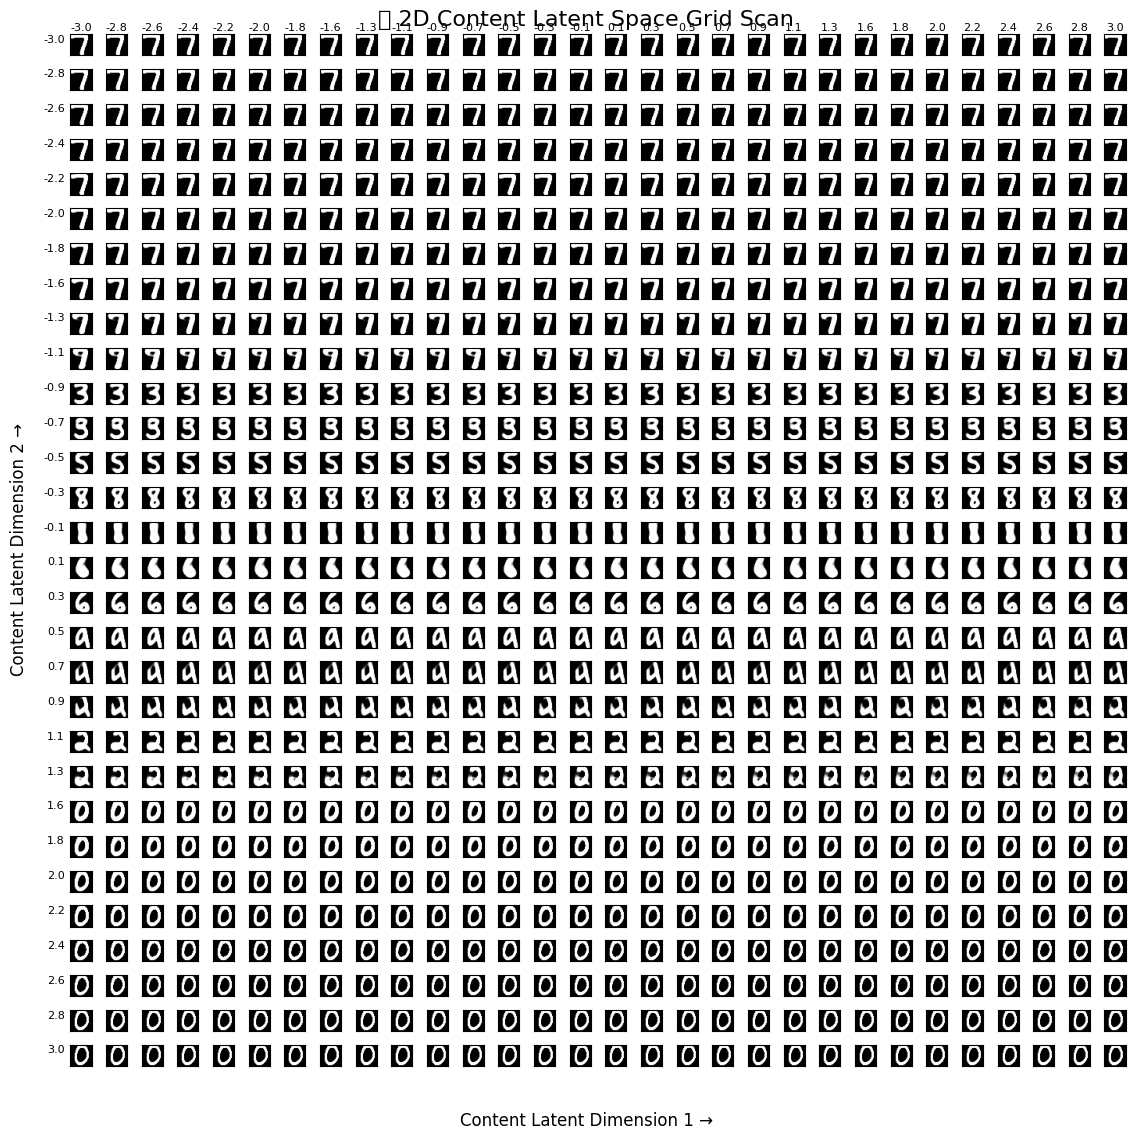

✅ Grid scan complete! Generated 30×30 = 900 images
📏 Scanned range: [-3.0, 3.0] in both dimensions


In [14]:
# 🌟 LATENT SPACE GRID SCAN - MAIN FEATURE
# This creates a grid of digits by scanning through the 2D content latent space

if model_loaded:
    print("🎨 Creating latent space grid scan...")
    
    # Create the grid using the visualization module
    grid_images, x_vals, y_vals = viz.create_latent_space_grid(
        model, device, 
        grid_size=VIZ_CONFIG['grid_size'], 
        latent_range=VIZ_CONFIG['latent_range']
    )
    
    # Plot the grid
    viz.plot_latent_space_grid(grid_images, x_vals, y_vals, 
                              VIZ_CONFIG['grid_size'], VIZ_CONFIG['latent_range'])

else:
    print("❌ Cannot create grid scan without loaded model.")

🎲 Analyzing random digit reconstructions...


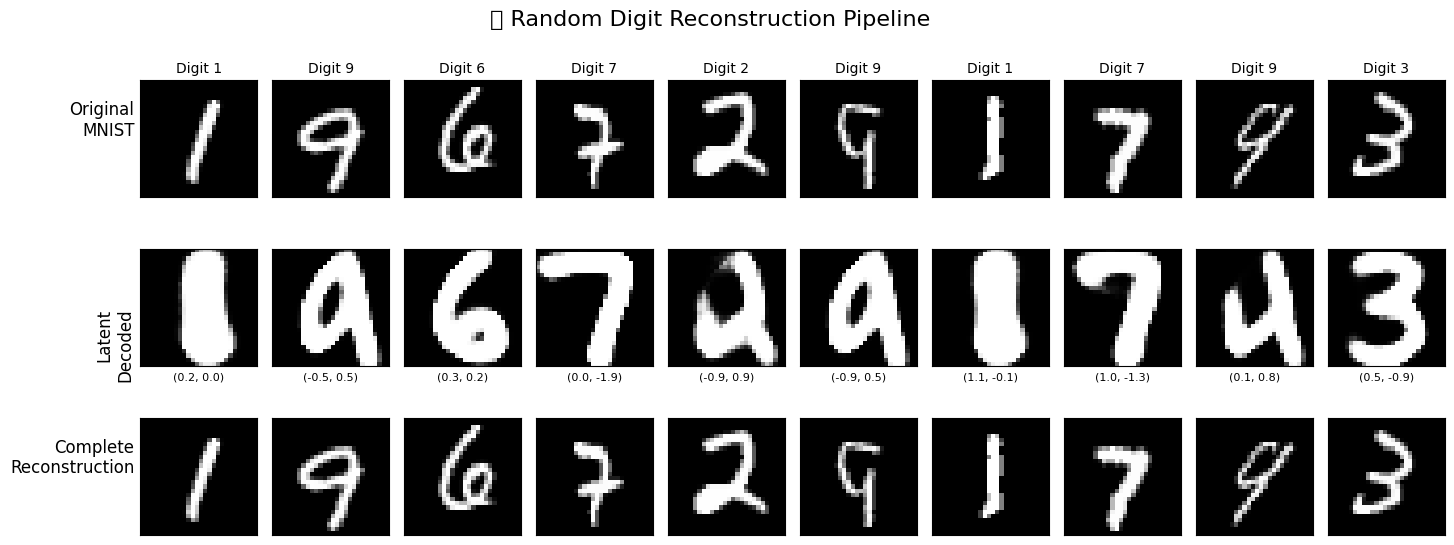


📊 RECONSTRUCTION QUALITY ANALYSIS:
Average Latent Reconstruction MSE: 1.0748
Average Complete Reconstruction MSE: 0.0000
Improvement from Affine Transform: 100.0%

🔢 PER-DIGIT ANALYSIS:
Digit 1: Content=(0.18, 0.01), Latent MSE=0.9882, Complete MSE=0.0000
Digit 9: Content=(-0.54, 0.55), Latent MSE=1.0658, Complete MSE=0.0000
Digit 6: Content=(0.31, 0.25), Latent MSE=1.0856, Complete MSE=0.0000
Digit 7: Content=(0.01, -1.93), Latent MSE=1.0625, Complete MSE=0.0000
Digit 2: Content=(-0.88, 0.94), Latent MSE=1.2487, Complete MSE=0.0000
Digit 9: Content=(-0.90, 0.52), Latent MSE=0.9047, Complete MSE=0.0000
Digit 1: Content=(1.06, -0.05), Latent MSE=1.1281, Complete MSE=0.0000
Digit 7: Content=(1.00, -1.34), Latent MSE=1.1925, Complete MSE=0.0000
Digit 9: Content=(0.06, 0.79), Latent MSE=0.8633, Complete MSE=0.0000
Digit 3: Content=(0.50, -0.87), Latent MSE=1.2086, Complete MSE=0.0000


In [16]:
# 🎲 RANDOM DIGIT RECONSTRUCTION ANALYSIS
# Sample 10 random digits and show their complete reconstruction pipeline

if model_loaded:
    print("🎲 Analyzing random digit reconstructions...")
    viz.analyze_random_reconstructions(model, test_loader, device, num_samples=10)
else:
    print("❌ Cannot analyze reconstructions without loaded model.")

🔍 Running complete latent space analysis...
🔍 Running complete latent space analysis...

🔍 Diagnosing actual latent space distribution...


🔍 ACTUAL LATENT SPACE RANGES FOR EACH DIGIT:
Digit 0: Dim1 [-2.57, 1.98], Dim2 [1.15, 3.43]
Digit 1: Dim1 [-2.40, 2.84], Dim2 [-0.65, 0.18]
Digit 2: Dim1 [-3.29, 2.66], Dim2 [-2.32, 1.37]
Digit 3: Dim1 [-2.76, 2.25], Dim2 [-1.60, 0.88]
Digit 4: Dim1 [-2.51, 2.77], Dim2 [-1.51, 1.10]
Digit 5: Dim1 [-2.74, 3.07], Dim2 [-1.00, 0.18]
Digit 6: Dim1 [-2.25, 2.14], Dim2 [-0.41, 1.50]
Digit 7: Dim1 [-2.70, 2.44], Dim2 [-2.77, 0.88]
Digit 8: Dim1 [-2.54, 2.17], Dim2 [-1.17, 0.43]
Digit 9: Dim1 [-1.85, 3.09], Dim2 [-1.42, 0.83]

📊 OVERALL STATISTICS:
Full Range: Dim1 [-3.29, 3.09], Dim2 [-2.77, 3.43]
Mean: Dim1 -0.06, Dim2 -0.06
Std:  Dim1 0.98, Dim2 1.06

💡 SUGGESTED GRID SCAN RANGE: 3.8
   (This would scan [-3.8, 3.8] in both dimensions)


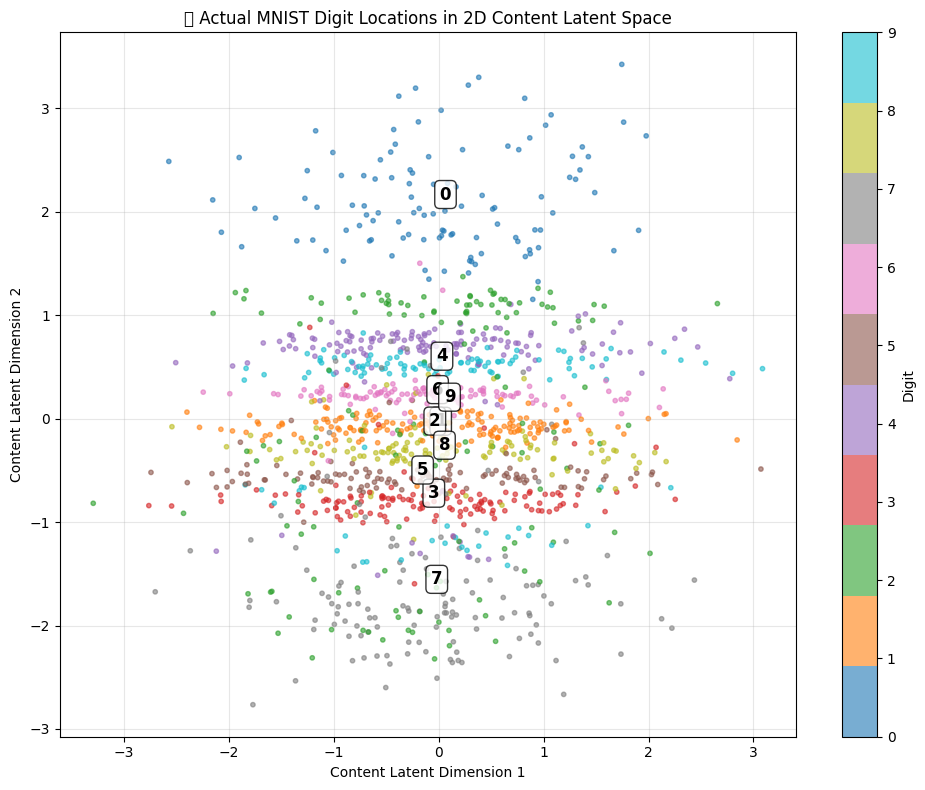


🔧 UPDATING GRID SCAN RANGE:
Current range: 3.0
Suggested range: 3.8

🎨 Creating latent space grid scan...


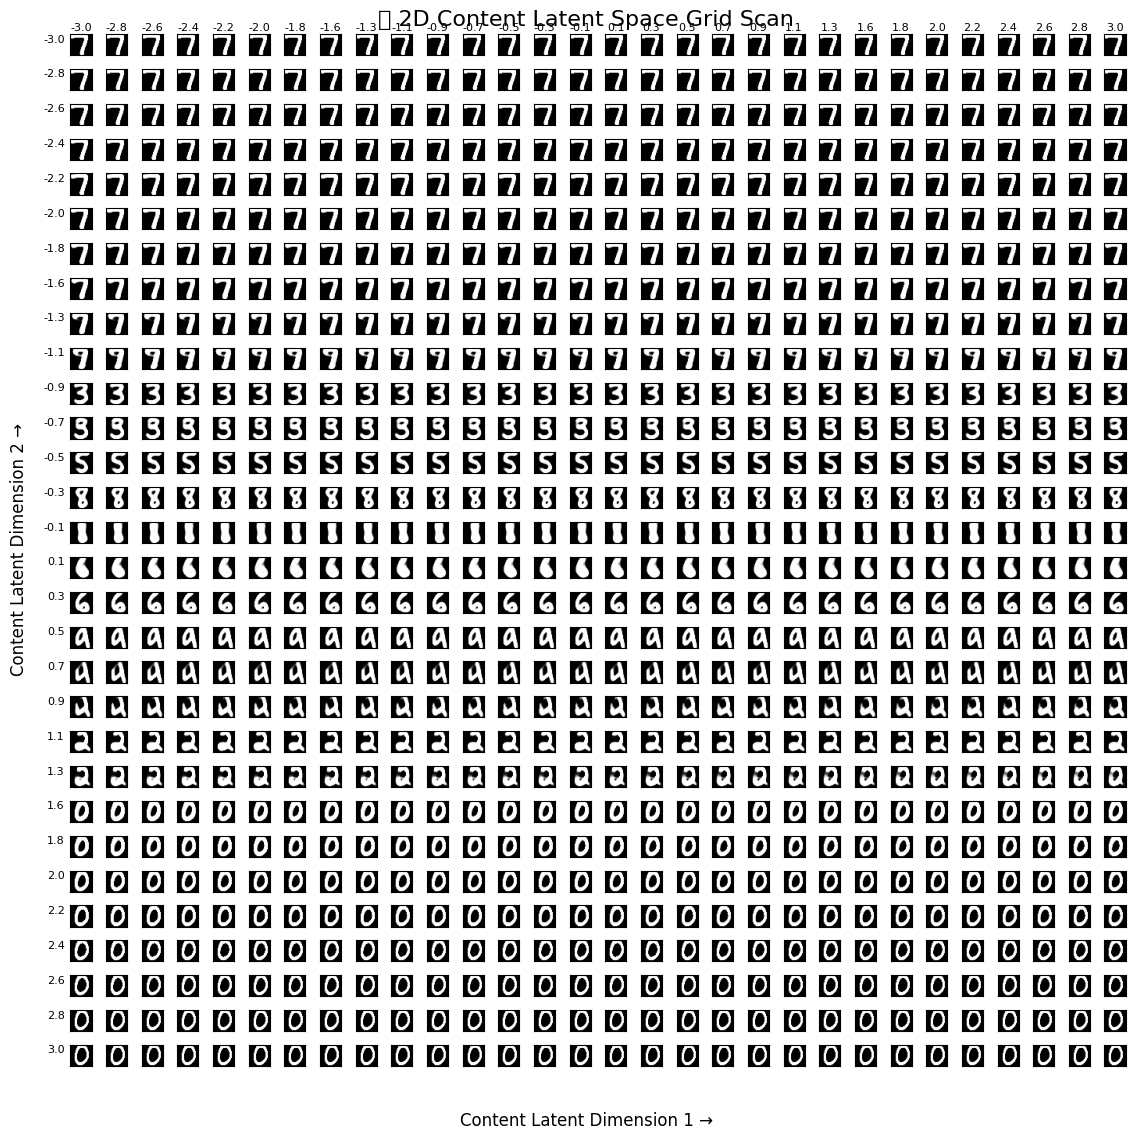

✅ Grid scan complete! Generated 30×30 = 900 images
📏 Scanned range: [-3.0, 3.0] in both dimensions


In [17]:
# 🔍 COMPLETE LATENT SPACE ANALYSIS
# Run comprehensive latent space diagnostic and visualization

if model_loaded:
    print("🔍 Running complete latent space analysis...")
    content_data, labels, suggested_range = viz.run_complete_latent_analysis(
        model, test_loader, device, VIZ_CONFIG
    )
    
    # Update config with suggested range if desired
    # VIZ_CONFIG['latent_range'] = suggested_range
    
else:
    print("❌ Cannot run latent analysis without loaded model.")